In [ ]:
import pyabf
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob 
from ephys_functions import detect_peaks, count_peaks_selected_sweeps, count_peaks, plot_by_genotype


def process_last10_and_plot(csv_file_path, output_dir='/Users/rbondare/ephys/results'):
    # Load metadata
    file_info = pd.read_csv(csv_file_path, delimiter=';')
    # Remove rows with missing files
    file_info = file_info[file_info['filepath'].apply(os.path.exists)]
    if file_info.empty:
        print("No valid files found.")
        return

    # Remove previous results file if exists (optional, for clean run)
    results_csv = os.path.join(output_dir, "selected_sweeps_peak_results.csv")
    if os.path.exists(results_csv):
        os.remove(results_csv)

    # Count peaks for each file (last 10 sweeps)
    for i, (_, row) in enumerate(file_info.iterrows()):
        print(f"Processing file {i+1}/{len(file_info)}: {row['filepath']}")
        count_peaks_selected_sweeps(
            abf_file=row['filepath'],
            condition=row['condition'],
            genotype=row['genotype'],
            ID=row['ID'],
            comment=row['comment']
            time_window=(0.5, 0.515),
            peak_params=None,
            output_dir=output_dir
        )

    # Now aggregate and plot
    results_df = pd.read_csv(results_csv)
    # Group by cell_ID and genotype, pivot to wide format
    print("Columns in results_df:", results_df.columns.tolist())
    print(results_df.head())
    pivot = results_df.pivot_table(
        index=['ID', 'genotype'],
        columns='condition',
        values='normalized_peaks'
    ).reset_index()
    # Rename columns for plotting function compatibility
    plot_by_genotype(pivot)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (620842393.py, line 33)

In [2]:
process_last10_and_plot("/Users/rbondare/ephys/metadata/ephys_all_data.csv")



Processing file 1/90: /Volumes/group/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0002.abf


TypeError: count_peaks_selected_sweeps() missing 1 required positional argument: 'comment'

In [8]:
file_info = pd.read_csv("/Users/rbondare/ephys/metadata/ephys_all_data.csv", delimiter=';')
file_info['filepath'] = file_info['filepath'].str.strip()  # Remove whitespace
print(file_info['filepath'].tolist())  # Debug: print all file paths
file_info = file_info[file_info['filepath'].apply(os.path.exists)]



['/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0002.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0003.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0004.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0007.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0008.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0009.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0012.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0013.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/24.03.2025 M1/2025_03_24_0014.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/25.03.2025 M2/2025_03_25_0004.abf', '/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/gad/25.03.2025 M

Columns in results_df: ['file', 'condition', 'genotype', 'ID', 'total_peaks', 'total_sweeps', 'normalized_peaks']
                  file      condition    genotype  ID  total_peaks  \
0  2025_03_24_0002.abf       baseline  eGFP-Gad67   1           10   
1  2025_03_24_0003.abf  Noradrenaline  eGFP-Gad67   1           10   
2  2025_03_24_0004.abf           wash  eGFP-Gad67   1           10   
3  2025_03_24_0007.abf       baseline  eGFP-Gad67   2           10   
4  2025_03_24_0008.abf  Noradrenaline  eGFP-Gad67   2           10   

   total_sweeps  normalized_peaks  
0            10               1.0  
1            10               1.0  
2            10               1.0  
3            10               1.0  
4            10               1.0  


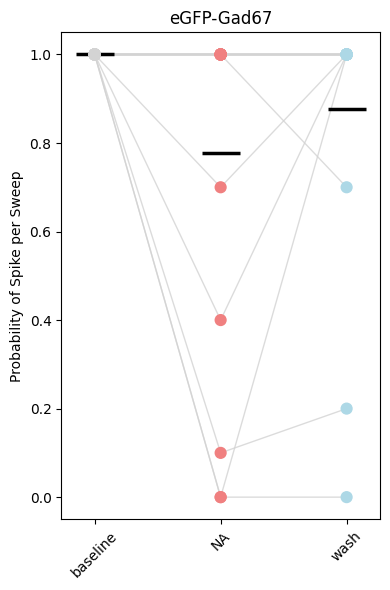

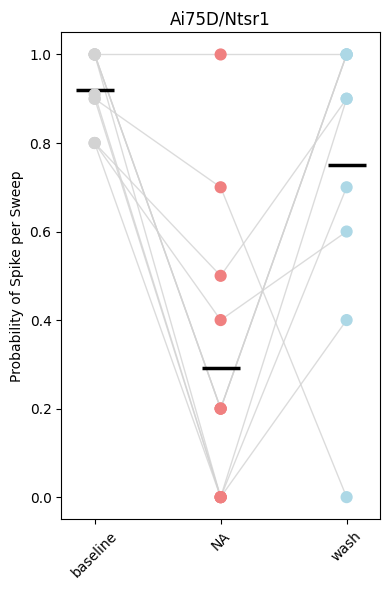

In [11]:
results_csv = "/Users/rbondare/ephys/results/selected_sweeps_first_peak_results.csv"
results_df = pd.read_csv(results_csv, delimiter=';')
print("Columns in results_df:", results_df.columns.tolist())
print(results_df.head())
pivot = results_df.pivot_table(
    index=['ID', 'genotype'],
    columns='condition',
    values='normalized_peaks'
).reset_index()

plot_by_genotype(pivot)